In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
import numpy as np
import random
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split      # dividing the dataset



Exploratory data analysis 

In [4]:
# Basic review of the images directory

def dataset_analysis(path):
    subfolders = os.listdir(path)
    print(f"Four conditions : ", subfolders)
    i=0
    total_images = 0
    image_extensions=['.jpg', '.jpeg', '.png']
    
    for root, dirs, files in os.walk(path):
        for file in files:
            # Check if the file has a valid image extension
            if any(file.lower().endswith(ext) for ext in image_extensions):
                total_images += 1
    
    print(f"Total number of images: {total_images}")
        
    for subfolder in subfolders:
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            files = os.listdir(subfolder_path)
            format_dimensions_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

            for file in files:
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        image_type = img.format.upper()  # Format (e.g., JPEG, PNG)
                        image_dimensions = img.size  # (width, height)
                        image_mode = img.mode  #  (e.g., RGB, L)
                        
                        # Calculate bit depth
                        if image_mode == "1":  # 1-bit pixels, black and white, stored with one pixel per byte
                            bit_depth = 1
                        elif image_mode == "L":  # 8-bit pixels, grayscale
                            bit_depth = 8
                        elif image_mode == "P":  # 8-bit pixels, mapped to any other mode using a color palette
                            bit_depth = 8
                        elif image_mode == "RGB":  # 8-bit pixels, true color
                            bit_depth = 24  # 8 bits per channel
                        elif image_mode == "RGBA":  # 8-bit pixels, true color with transparency mask
                            bit_depth = 32  # 8 bits per channel
                        elif image_mode == "CMYK":  # 8-bit pixels, color separation
                            bit_depth = 32  # 8 bits per channel
                        else:
                            bit_depth = "Unknown"
                        
                        format_dimensions_counts[image_type][(image_dimensions, bit_depth)][image_mode] += 1
                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")
                    
            print('--------'*10)
            i=i+1
            print(f" {i}- '{subfolder}': {len(files)}")
            for format, dimensions_counts in format_dimensions_counts.items():
                print(f"   * {sum(sum(counts.values()) for counts in dimensions_counts.values())} images of format {format}:")
                for (dimensions, bit_depth), counts in dimensions_counts.items():
                    for mode, count in counts.items():
                        print(f"     - {count} images with dimensions {dimensions}, bit depth {bit_depth}, mode {mode}")
                        
dataset_path = 'C:/Users/PC_I/OneDrive/Desktop/eye-diseases-classification/dataset/'
dataset_analysis(dataset_path)


Four conditions :  ['Cataract', 'diabetic_retinopathy', 'Glaucoma', 'Normal']
Total number of images: 4217
--------------------------------------------------------------------------------
 1- 'Cataract': 1038
   * 938 images of format JPEG:
     - 298 images with dimensions (512, 512), bit depth 24, mode RGB
     - 640 images with dimensions (256, 256), bit depth 24, mode RGB
   * 100 images of format PNG:
     - 76 images with dimensions (2592, 1728), bit depth 24, mode RGB
     - 5 images with dimensions (1848, 1224), bit depth 24, mode RGB
     - 19 images with dimensions (2464, 1632), bit depth 24, mode RGB
--------------------------------------------------------------------------------
 2- 'diabetic_retinopathy': 1098
   * 1098 images of format JPEG:
     - 1098 images with dimensions (512, 512), bit depth 24, mode RGB
--------------------------------------------------------------------------------
 3- 'Glaucoma': 1007
   * 906 images of format JPEG:
     - 306 images with dimensi

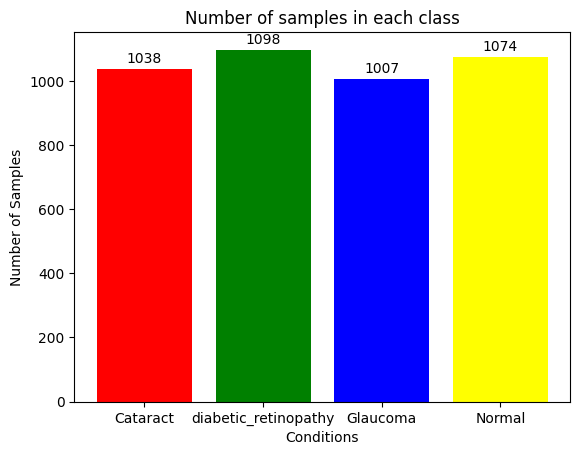

In [5]:
# Count the number of images in each directory
subfolders = os.listdir(dataset_path)

image_counts = []
for directory in subfolders:
    sub_dir = os.path.join(dataset_path, directory)
    if os.path.isdir(sub_dir):
        file_count = len(os.listdir(sub_dir))
        image_counts.append(file_count)
        
#Add value counts on each bar
for i in range(len(subfolders)):
    plt.text(i, image_counts[i]+10, str(image_counts[i]), ha='center', va='bottom')
    
#Set some colors
colors = ['Red', 'Green', 'Blue', 'yellow']
#Condi = ['Cataract', 'DR', 'Glaucoma', 'Normal']
 
# Plotting the results
plt.bar(subfolders, image_counts, color=colors)
plt.xlabel('Conditions')
plt.ylabel('Number of Samples')
plt.title('Number of samples in each class')
plt.show()

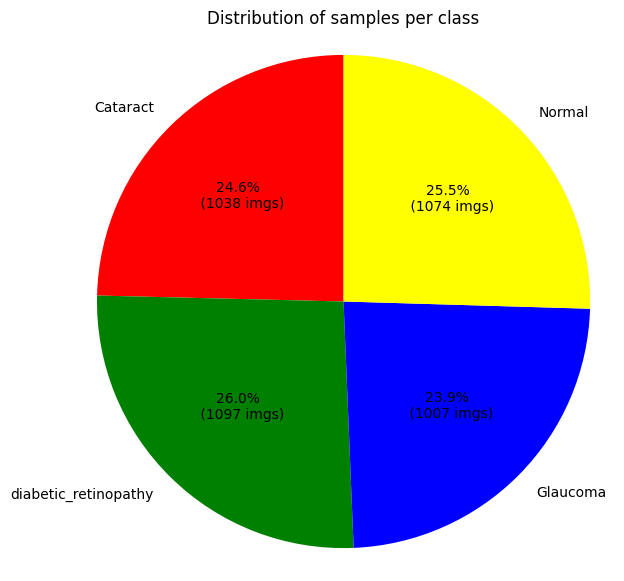

In [7]:
# # Calculate the number of images per class
# class_counts = df['class'].value_counts()
# 
# # Get the encoded labels and corresponding image counts
# class_sizes = class_counts.values  # Number of images in each class
# 
# # Use LabelEncoder to get the original class names (before encoding)
# class_labels = label_encoder.inverse_transform(class_counts.index)

# Custom function to display both the number of images and percentage
def autopct_format(pct, sizes):
    total = sum(sizes)
    actual = int(total * pct / 100)  # Directly calculate the actual number of images
    return f"{pct:.1f}% \n ({actual} imgs)"  # Format: percentage and image count

# Plot the pie chart
plt.figure(figsize=(7, 7))  # Adjust the figure size
plt.pie(image_counts, labels=subfolders, autopct=lambda pct: autopct_format(pct, image_counts),
        startangle=90, colors=colors)

# Add a title
plt.title('Distribution of samples per class')

# Ensure the pie chart is a circle
plt.axis('equal')

# Display the plot
plt.show()


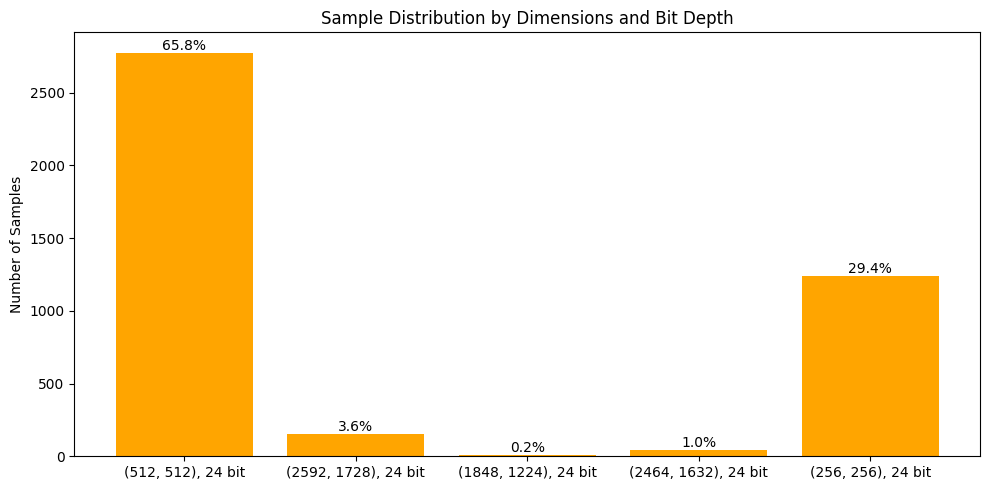

In [8]:
# Check the photos by size

def dataset_size_analysis(path):
    format_dimensions_counts = defaultdict(int)

    subfolders = os.listdir(path)
    for subfolder in subfolders:
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            files = os.listdir(subfolder_path)

            for file in files:
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        image_dimensions = img.size
                        image_mode = img.mode

                        # Calculate bit depth
                        bit_depth = {
                            "1": 1,
                            "L": 8,
                            "P": 8,
                            "RGB": 24,
                            "RGBA": 32,
                            "CMYK": 32
                        }.get(image_mode, "Unknown")

                        # Update counts
                        format_dimensions_counts[(image_dimensions,bit_depth)] += 1

                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")

    # Plotting dimensions and bit depths
    plt.figure(figsize=(10, 5))
    labels = [f"{dims}, {depth} bit" for (dims, depth) in format_dimensions_counts]
    sizes = list(format_dimensions_counts.values())
    total = sum(sizes)
    bars = plt.bar(labels, sizes, color='Orange')
   # plt.xticks(rotation=45, ha="right")
    plt.ylabel('Number of Samples')
    plt.title('Sample Distribution by Dimensions and Bit Depth')

    # Adding percentage labels above the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{100 * yval/total:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Set the path to the dataset directory
dataset_size_analysis(dataset_path)

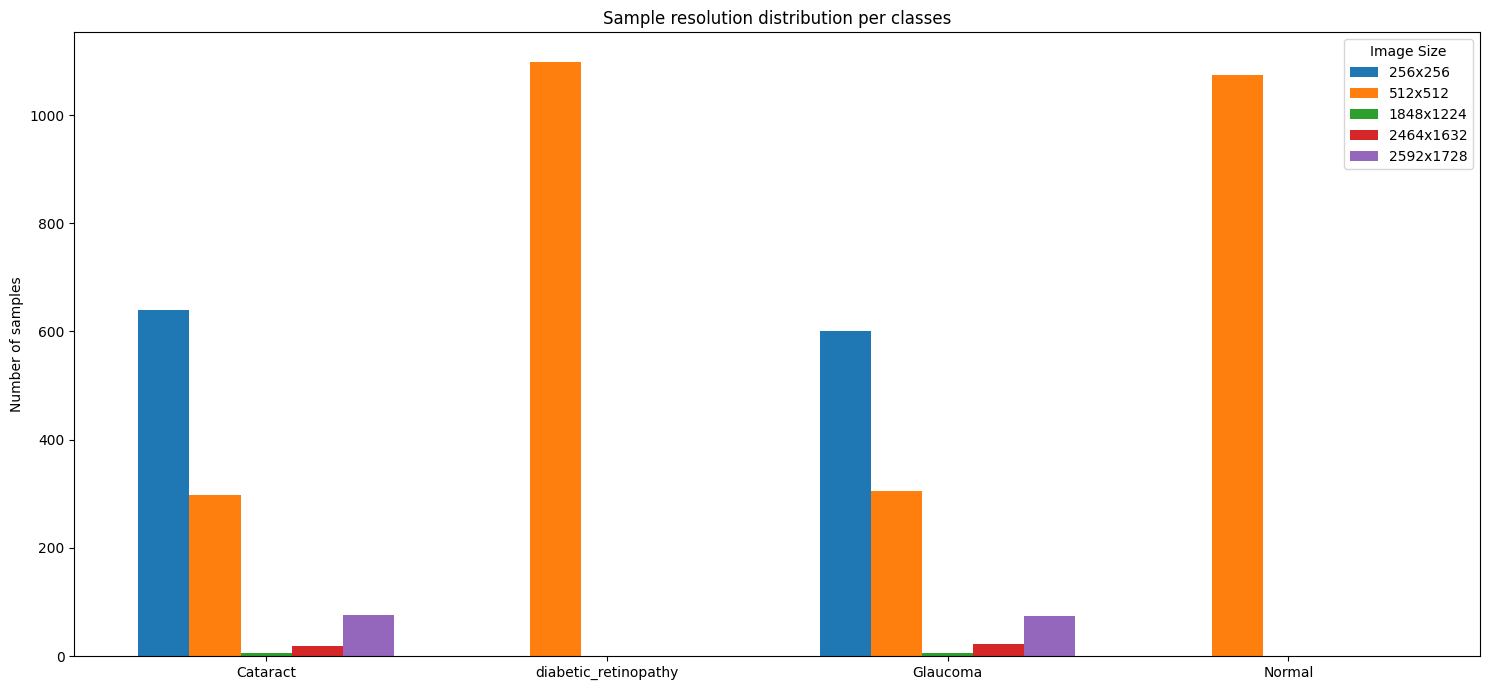

In [9]:
#Sample resolution distribution per classes

def dataset_size_analysis(path):
    # Dictionary to store counts: {subfolder: {image_size: count}}
    folder_size_counts = defaultdict(lambda: defaultdict(int))

    for subfolder in os.listdir(path):
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        dims = img.size
                        folder_size_counts[subfolder][dims] += 1
                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")

    # Create a single plot
    plt.figure(figsize=(15, 7))
    
    # Determine unique image sizes across all folders for consistent coloring and grouping
    all_sizes = set(size for sizes in folder_size_counts.values() for size in sizes)
    all_sizes = sorted(all_sizes, key=lambda s: (s[0] * s[1]))  # Sort by area

    subfolder_names = list(folder_size_counts.keys())
    bar_width = 0.15  # Width of bars
    indices = range(len(subfolder_names))

    for i, size in enumerate(all_sizes):
        counts = [folder_size_counts[subfolder].get(size, 0) for subfolder in subfolder_names]
        plt.bar([index + i * bar_width for index in indices], counts, bar_width, label=f'{size[0]}x{size[1]}')

    plt.xticks([index + (len(all_sizes) - 1) * bar_width / 2 for index in indices], subfolder_names, ha="center")
    plt.ylabel('Number of samples')
    plt.title('Sample resolution distribution per classes')
    plt.legend(title="Image Size")
    plt.tight_layout()
    plt.show()

# Set the path to the dataset directory
dataset_size_analysis(dataset_path)


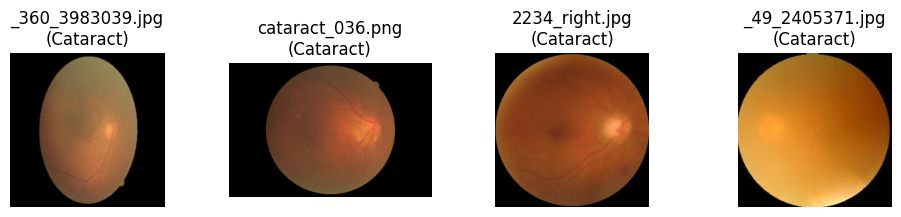

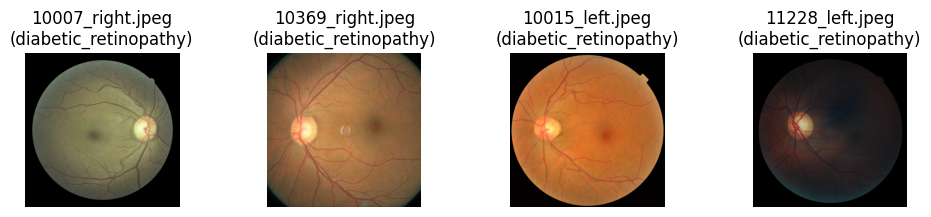

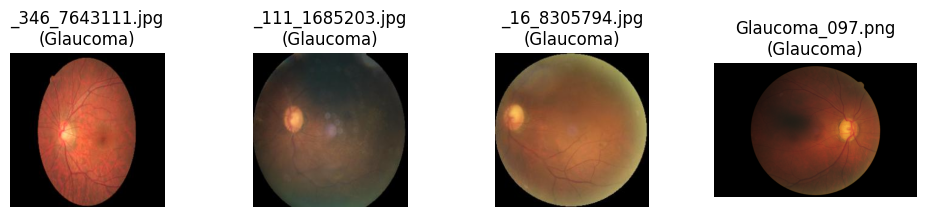

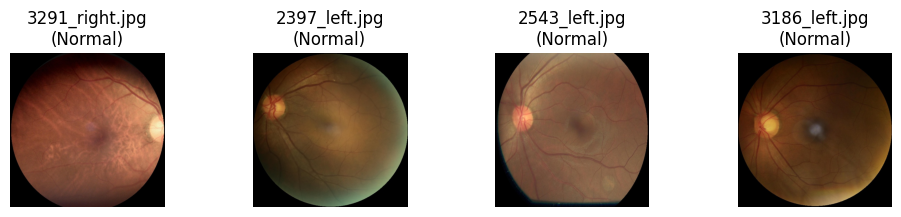

In [10]:
# Preview samples

def random_photos_from_folders(base_folder):
    # Walk through all directories and files in the base_folder
    for root, dirs, files in os.walk(base_folder):
        # Filter to get only files that are images
        images = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if len(images) >= 4:  # Ensure there are at least 4 images
            selected_images = random.sample(images, 4)  # Randomly select 4 images
            
            # Display selected images
            fig, axs = plt.subplots(1, 4, figsize=(12, 2))  # Create a 1x4 grid of plots
            for idx, img_name in enumerate(selected_images):
                img_path = os.path.join(root, img_name)
                img = Image.open(img_path)
                axs[idx].imshow(img)
                axs[idx].axis('off')  # Hide axes
                
                # Extract sub-folder name from the root path
                subfolder_name = os.path.basename(root)
                # Set the title to include image name and sub-folder name
                axs[idx].set_title(f"{img_name}\n({subfolder_name})")
                
            plt.show()

# Path to the folder containing sub-folders with images

random_photos_from_folders(dataset_path)

Data preparation

In [11]:
# Get the names of the classes
class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Create data path and their labels
data = []  # List to store the image paths
labels = []  # List to store the class labels
extensions = ["jpg", "jpeg", "png", "bmp", "gif"]  # Lowercase to standardize extensions

for class_label in class_dirs:
    for ext in extensions:
        # Search for files with each extension and append both data and label simultaneously
        image_files = glob.glob(os.path.join(dataset_path, class_label, f"*.{ext.lower()}"))
        data.extend(image_files)  # Append image paths
        labels.extend([class_label] * len(image_files))  # Append corresponding labels
 
# Check if lists are empty
if not data:
    print("No files were found. Check your directory paths and file formats.")
else:
    print(f"Found {len(data)} images in total.")

# Create a Pandas DataFrame
df = pd.DataFrame({
    'filename': data,
    'class': labels
})

# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

# Display DataFrame
print(df.head())  # Display the first few rows of DataFrame
print(df['class'].value_counts())  # Display the distribution of images across classes
 
# Save the DataFrame to a CSV file
try:
    output_csv_path = 'C:/Users/PC_I/OneDrive/Desktop/your_dataframe2.csv'
    df.to_csv(output_csv_path, index=False)
    print(f"DataFrame saved successfully to {output_csv_path}")
except PermissionError as e:
    print(f"PermissionError: {e}")
    print("Try saving to a different directory.")



Found 4217 images in total.
                                            filename                 class
0  C:/Users/PC_I/OneDrive/Desktop/eye-diseases-cl...              Glaucoma
1  C:/Users/PC_I/OneDrive/Desktop/eye-diseases-cl...  diabetic_retinopathy
2  C:/Users/PC_I/OneDrive/Desktop/eye-diseases-cl...  diabetic_retinopathy
3  C:/Users/PC_I/OneDrive/Desktop/eye-diseases-cl...              Cataract
4  C:/Users/PC_I/OneDrive/Desktop/eye-diseases-cl...  diabetic_retinopathy
class
diabetic_retinopathy    1098
Normal                  1074
Cataract                1038
Glaucoma                1007
Name: count, dtype: int64
DataFrame saved successfully to C:/Users/PC_I/OneDrive/Desktop/your_dataframe2.csv


In [12]:
# Convert labels to one-hot encodings
label_encoder = LabelEncoder()
label = label_encoder.fit_transform(df['class'])
df['class'] = label

# check number assigned to each class
# Get the class names and corresponding integer encodings
class_names = label_encoder.classes_
class_numbers = label_encoder.transform(label_encoder.classes_)

# Print class names with the assigned numbers
class_dict = dict(zip(class_names, class_numbers))

print(class_dict)

{'Cataract': np.int64(0), 'Glaucoma': np.int64(1), 'Normal': np.int64(2), 'diabetic_retinopathy': np.int64(3)}


In [29]:
display(df)

,filename,class
0,C:/Users/PC_I/OneDrive/Desktop/eye-diseases-cl...,0
1,C:/Users/PC_I/OneDrive/Desktop/eye-diseases-cl...,0
2,C:/Users/PC_I/OneDrive/Desktop/eye-diseases-cl...,1
3,C:/Users/PC_I/OneDrive/Desktop/eye-diseases-cl...,1
4,C:/Users/PC_I/OneDrive/Desktop/eye-diseases-cl...,3
...,...,...
4212,C:/Users/PC_I/OneDrive/Desktop/eye-diseases-cl...,0
4213,C:/Users/PC_I/OneDrive/Desktop/eye-diseases-cl...,2
4214,C:/Users/PC_I/OneDrive/Desktop/eye-diseases-cl...,3
4215,C:/Users/PC_I/OneDrive/Desktop/eye-diseases-cl...,1


In [13]:
# Check the balance of the classes
print(df['class'].value_counts())
print('------'*10)

# Split the data into train+validation and test sets
train_val, test = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

# Split the train+validation set into train and validation sets
train, val = train_test_split(train_val, test_size=0.25, stratify=train_val['class'], random_state=42)  # 0.25 x 0.8 = 0.2

# Now we have:
# train: 60% of the data
# val: 20% of the data
# test: 20% of the data

# Confirm the distribution across splits
print("Training set:")
print(train['class'].value_counts())
print('------'*10)


print("Validation set:")
print(val['class'].value_counts())
print('------'*10)


print("Test set:")
print(test['class'].value_counts())

class
3    1098
2    1074
0    1038
1    1007
Name: count, dtype: int64
------------------------------------------------------------
Training set:
class
3    658
2    644
0    622
1    605
Name: count, dtype: int64
------------------------------------------------------------
Validation set:
class
3    220
2    215
0    208
1    201
Name: count, dtype: int64
------------------------------------------------------------
Test set:
class
3    220
2    215
0    208
1    201
Name: count, dtype: int64


In [21]:
import pandas as pd

# Create a dictionary to store the distributions for each split
split_distribution = {
    'Set': ['Training', 'Validation', 'Test'],
    '(%)': [len(train) / len(df) * 100, len(val) / len(df) * 100, len(test) / len(df) * 100],
    'No.of Samples': [len(train), len(val), len(test)]
}
 
# Get class distributions for each set
for class_label in df['class'].unique():
    split_distribution[class_label] = [
        train['class'].value_counts().get(class_label, 0),
        val['class'].value_counts().get(class_label, 0),
        test['class'].value_counts().get(class_label, 0)
    ]

# Convert the dictionary to a pandas DataFrame
split_df = pd.DataFrame(split_distribution)

# Display the table
print(split_df)


          Set        (%)  No.of Samples    1    3    0    2
0    Training  59.971544           2529  605  658  622  644
1  Validation  20.014228            844  201  220  208  215
2        Test  20.014228            844  201  220  208  215
